# Logistic Regression

In [1]:
#!pip install imblearn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from src import log_reg_utils

## UDF

## Import Dataset

In [2]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)

In [3]:
accidents.head(2)

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,was_dark_no_lighting,is_day,is_evening,is_morning,is_night,season,is_fall,is_spring,is_summer,is_winter
0,JC343143,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,NaN,...,0,1,0,0,0,summer,0,0,1,0
1,JC194776,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,4.0,...,0,0,0,0,1,spring,0,1,0,0


## Process Data for Model

In [4]:
X = accidents[['is_weekend',
               'involved_pedest_cycle',
               'at_stop_sign_or_traffic_light',
               'is_day',
               'is_evening',
               'is_morning',
               'is_night',
               'is_rain',
               'is_sleet_snow',
               'is_spring',
               'is_summer',
               'is_winter',
               'is_fall',
               'was_non_functioning_device',
               'was_head_on',
               'was_parked']]



y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [5]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=3)
#oversampler = SMOTE(sampling_strategy=0.5, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning

In [7]:
#solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values =  [0.01, 0.1, 1.0, 10, 100]
params_grid = dict(C=c_values)

In [8]:
log_reg = LogisticRegression(max_iter=1000, fit_intercept=True, random_state=3)

clf = GridSearchCV(log_reg, params_grid, cv=5, verbose=0, scoring='recall')

best_model = clf.fit(X_over, y_over)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [9]:
print('Best Solver: ', best_model.best_estimator_.get_params()['solver'])
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Solver:  newton-cg
Best C:  0.01


### Train and Predict

In [10]:
solver='newton-cg'
c=0.01

log_reg = LogisticRegression(solver=solver, C=c, max_iter=1000, fit_intercept=True, random_state=3)
log_reg.fit(X_over, y_over)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[55420  2130]
 [  712   353]]


Recall (Scores FN):  0.3315
Precision (Scores FP):  0.1422
AUC Score:  0.7077


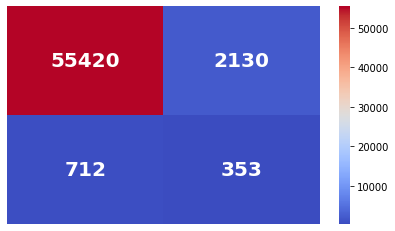

In [11]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

In [12]:
coef_summary = pd.DataFrame()
coef_summary['feature_name'] = pd.Series(X.columns)
coef_summary['log_reg_coef'] = pd.Series(log_reg.coef_[0])
coef_summary.sort_values('log_reg_coef', inplace = True, ascending=False)
coef_summary

,feature_name,log_reg_coef
1,involved_pedest_cycle,2.542183
2,at_stop_sign_or_traffic_light,0.464265
6,is_night,0.363591
7,is_rain,0.193796
0,is_weekend,0.131676
10,is_summer,0.023541
9,is_spring,0.004426
12,is_fall,0.002668
11,is_winter,-0.030637
5,is_morning,-0.054263


In [35]:
print('Intercept: ', log_reg.intercept_[0])

Intercept:  -1.0178380175028572


### Test for Multicolinearity

In [36]:
type(X_over)
y_over.shape

(345027,)

In [51]:
X_over_incl_const = sm.add_constant(X_over)
model = sm.Logit(y_over, X_over_incl_const)
results = model.fit(method='newton')
results.summary()

         Current function value: 0.545249
         Iterations: 35


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      is_fatal_or_incap   No. Observations:               345027
Model:                          Logit   Df Residuals:                   345014
Method:                           MLE   Df Model:                           12
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.1434
Time:                        19:49:12   Log-Likelihood:            -1.8813e+05
converged:                      False   LL-Null:                   -2.1961e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0967        nan        nan        nan         nan         nan
x1            -0.0069      0.016     -0.428      0.669      -0.039       0.025
x2             0.1334      0.009     14.778      0.000       0.116       0.151
x3            -0.2915      0.021    -14.047      0.000      -0.332      -0.251
x4             2.5797      0.013    202.493      0.000       2.555       2.605
x5             0.4673      0.008     58.033      0.000       0.451       0.483
x6            -0.1006      0.012     -8.254      0.000      -0.124      -0.077
x7             0.0562      0.014      4.006      0.000       0.029       0.084
x8             0.4759      0.014     34.168      0.000       0.449       0.503
x9             0.1924      0.013     14.830      0.000       0.167       0.218
x10           -0.2729        nan        nan        nan         nan         nan
x11           -0.2758        nan        nan        nan         nan         nan
x12           -0.2571        nan        nan        nan         nan         nan
x13           -0.2910        nan        nan        nan         nan         nan
==============================================================================
"""

In [52]:
X_over_df = pd.DataFrame(X_over, columns=X.columns)
log_reg_utils.calc_vif(X_over_df)

,features,VIF
0,crash_month,1.714390
1,is_weekend,1.039810
2,has_snow_ice,1.092479
3,involved_pedest_cycle,1.012390
4,at_stop_sign_or_traffic_light,1.006565
5,is_day,2.248532
6,is_morning,1.897415
7,is_night,1.866965
8,is_rain,1.017394
9,is_fall,6.584173
